In [34]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as scipy_stats

from plot_utilities import (
    setup_notebook_display,
    plot_coefficient_heatmap,
    load_panel_data,
    sort_player_types,
    MODEL_COLORS,
    get_player_color,
)
from ratings import calculate_strategy_ratings

setup_notebook_display(figsize=(10, 6))

df = pd.read_csv('player_strength_panel.csv')

# Derive dominant strategy from strategy ratios
strategy_cols = ['domination_ratio', 'culture_ratio', 'diplomatic_ratio', 'science_ratio']
strategy_labels = {c: c.replace('_ratio', '').title() for c in strategy_cols}
df['dominant_strategy'] = df[strategy_cols].idxmax(axis=1).map(strategy_labels)

player_types = sort_player_types(df['player_type'].unique())
strategies = sorted(strategy_labels.values())

print(f'Loaded {len(df)} rows, {df["player_type"].nunique()} player types, {df["game_id"].nunique()} games')
print(f'Dominant strategies: {strategies}')

Loaded 2856 rows, 16 player types, 357 games
Dominant strategies: ['Culture', 'Diplomatic', 'Domination', 'Science']


## Strategy Distribution

Cross-tab of player type by dominant strategy — how many games each player type pursues each strategy.

In [35]:
ct = pd.crosstab(df['player_type'], df['dominant_strategy'])
ct = ct.reindex(player_types)
ct['Total'] = ct.sum(axis=1)
ct

dominant_strategy     Culture  Diplomatic  Domination  Science  Total
player_type                                                          
Null                        7          52          59       82    200
Vanilla                    60         221         379      322    982
Deepseek-3.2-Briefed       14          59          25       15    113
Deepseek-3.2-Simple        10          27          60       16    113
GLM-4.7-Briefed            45          41          24       69    179
GLM-4.7-Simple             35          36          33       75    179
GPT-OSS-120B-Briefed       12          93           7       44    156
GPT-OSS-120B-Simple        19          68          27       42    156
Kimi-K2.5-Briefed          19          35          17       96    167
Kimi-K2.5-Simple           22          28          35       82    167
Minimax-M2.5-Briefed       42          24          39       13    118
Minimax-M2.5-Simple        48          15          40       15    118
Qwen-3.5-Briefed            9          48           8       11     76
Qwen-3.5-Simple            16          31          23        6     76
Sonnet-4.5-Briefed          1           0           0       27     28
Sonnet-4.5-Simple           0           6           2       20     28

## Per-Strategy ELO Ratings

Bradley-Terry ELO using composite player identities (e.g., `Kimi-K2.5-Briefed-Science`). Each composite type is rated against the full field in a single BT run — no games are dropped.

In [36]:
strategy_elo = calculate_strategy_ratings(df, min_games=2, verbose=True)

pivot_elo = strategy_elo.pivot(index='player_type', columns='strategy', values='elo')
pivot_se = strategy_elo.pivot(index='player_type', columns='strategy', values='se_elo')

Composite types: 61
Will drop post-fit: 1 types with <2 games
CALCULATING RATINGS USING BRADLEY-TERRY MLE (R)

Total games: 357
Player types: ['Deepseek-3.2-Briefed-Culture', 'Deepseek-3.2-Briefed-Diplomatic', 'Deepseek-3.2-Briefed-Domination', 'Deepseek-3.2-Briefed-Science', 'Deepseek-3.2-Simple-Culture', 'Deepseek-3.2-Simple-Diplomatic', 'Deepseek-3.2-Simple-Domination', 'Deepseek-3.2-Simple-Science', 'GLM-4.7-Briefed-Culture', 'GLM-4.7-Briefed-Diplomatic', 'GLM-4.7-Briefed-Domination', 'GLM-4.7-Briefed-Science', 'GLM-4.7-Simple-Culture', 'GLM-4.7-Simple-Diplomatic', 'GLM-4.7-Simple-Domination', 'GLM-4.7-Simple-Science', 'GPT-OSS-120B-Briefed-Culture', 'GPT-OSS-120B-Briefed-Diplomatic', 'GPT-OSS-120B-Briefed-Domination', 'GPT-OSS-120B-Briefed-Science', 'GPT-OSS-120B-Simple-Culture', 'GPT-OSS-120B-Simple-Diplomatic', 'GPT-OSS-120B-Simple-Domination', 'GPT-OSS-120B-Simple-Science', 'Kimi-K2.5-Briefed-Culture', 'Kimi-K2.5-Briefed-Diplomatic', 'Kimi-K2.5-Briefed-Domination', 'Kimi-K2.5-B

## ELO Heatmap

Player type (rows) by strategy (columns), colored by ELO.

In [37]:
import seaborn as sns

pivot_display = pivot_elo.reindex(player_types).dropna(how='all')

# Game counts and percentages per player_type × strategy
pivot_n = strategy_elo.pivot(index='player_type', columns='strategy', values='n_games')
pivot_n = pivot_n.reindex(pivot_display.index, columns=pivot_display.columns)
pivot_pct = pivot_n.div(pivot_n.sum(axis=1), axis=0) * 100
pivot_se_display = pivot_se.reindex(pivot_display.index, columns=pivot_display.columns)

# Load canonical general BT ratings exported by turn_predicted.ipynb
general_bt = pd.read_csv('../ratings/output/orthodox_elo_ratings.csv').set_index('player_type')
general_elo = general_bt['elo']
general_se = general_bt['se_elo']
general_n = general_bt['n_games']

# Insert General column at position 0 (left side)
pivot_display.insert(0, 'General', general_elo)
pivot_se_display.insert(0, 'General', general_se)
pivot_n.insert(0, 'General', general_n)
pivot_pct.insert(0, 'General', np.nan)

# Vanilla baseline for z-tests
vanilla_elo = pivot_display.loc['Vanilla']
vanilla_se = pivot_se_display.loc['Vanilla']

def sig_stars(p):
    if pd.isna(p): return ''
    if p < 0.001: return '***'
    if p < 0.01: return '**'
    if p < 0.05: return '*'
    return ''

fig, ax = plt.subplots(figsize=(11, len(pivot_display) * 0.6 + 1))
sns.heatmap(pivot_display, annot=False, cmap='RdYlGn', center=1500,
            linewidths=0.5, ax=ax, cbar_kws={'label': 'ELO'})

# Custom two-line annotations: bold ELO ± SE on top, smaller (n, %) below
for i, pt in enumerate(pivot_display.index):
    for j, s in enumerate(pivot_display.columns):
        elo_val = pivot_display.loc[pt, s]
        if pd.isna(elo_val):
            continue
        se_val = pivot_se_display.loc[pt, s]

        # z-test: is ELO significantly different from Vanilla?
        van_elo = vanilla_elo[s]
        van_se = vanilla_se[s]
        if pt == 'Vanilla' or pd.isna(van_elo):
            stars = ''
        else:
            se_diff = np.sqrt(se_val**2 + van_se**2)
            z = (elo_val - van_elo) / se_diff if se_diff > 0 else 0
            p = 2 * (1 - scipy_stats.norm.cdf(abs(z)))
            stars = sig_stars(p)

        # Bold main ELO ± range with significance stars
        ax.text(j + 0.5, i + 0.38, f'{elo_val:.0f} ± {1.96*se_val:.0f}{stars}',
                ha='center', va='center', fontsize=11,
                color='black')

        # Smaller game count line
        n_val = pivot_n.iloc[i, j]
        if not pd.isna(n_val):
            pct_val = pivot_pct.iloc[i, j]
            if pd.isna(pct_val):
                # General column: show count only (no strategy percentage)
                ax.text(j + 0.5, i + 0.65, f'(n={int(n_val)})',
                        ha='center', va='center', fontsize=8, color='#444444')
            else:
                ax.text(j + 0.5, i + 0.65, f'(n={int(n_val)}, {pct_val:.0f}%)',
                        ha='center', va='center', fontsize=8, color='#444444')

ax.set_title('Per-Strategy ELO Ratings', fontweight='bold')
ax.set_ylabel('')
ax.set_xlabel('* p<0.05, ** p<0.01, *** p<0.001 (z-test vs Vanilla)', fontsize=8, color='#666666')
plt.tight_layout()
plt.show()

## Strategy Specialization

Delta from game-count-weighted overall ELO to per-strategy ELO. Positive = better than average at this strategy.

In [38]:
# Game counts per player_type × strategy
pivot_n = strategy_elo.pivot(index='player_type', columns='strategy', values='n_games')
pivot_n = pivot_n.reindex(pivot_elo.index, columns=pivot_elo.columns)

# Overall ELO per player type (game-count-weighted mean across strategies)
overall_elo = (pivot_elo * pivot_n).sum(axis=1) / pivot_n.sum(axis=1)

delta_df = pivot_elo.sub(overall_elo, axis=0)
delta_display = delta_df.reindex(player_types).dropna(how='all')

# Reindex counts/pcts to match display
pivot_n = pivot_n.reindex(delta_display.index, columns=delta_display.columns)
pivot_pct = pivot_n.div(pivot_n.sum(axis=1), axis=0) * 100
pivot_se_display = pivot_se.reindex(delta_display.index, columns=delta_display.columns)

max_abs = max(abs(delta_display.min().min()), abs(delta_display.max().max()), 1)

fig, ax = plt.subplots(figsize=(9, len(delta_display) * 0.6 + 1))
sns.heatmap(delta_display, annot=False, cmap='RdYlGn', center=0,
            vmin=-max_abs, vmax=max_abs, linewidths=0.5, ax=ax,
            cbar_kws={'label': 'ELO Delta'})

# Custom two-line annotations: bold delta ± SE on top, smaller (n, %) below
for i, pt in enumerate(delta_display.index):
    for j, s in enumerate(delta_display.columns):
        d_val = delta_display.loc[pt, s]
        if pd.isna(d_val):
            continue
        se_val = pivot_se_display.loc[pt, s]
        n_val = int(pivot_n.loc[pt, s])
        pct_val = pivot_pct.loc[pt, s]

        # z-test: is delta significantly different from 0?
        z = d_val / se_val if se_val > 0 else 0
        p = 2 * (1 - scipy_stats.norm.cdf(abs(z)))
        stars = sig_stars(p)

        # Bold delta ± range with significance stars
        ax.text(j + 0.5, i + 0.38, f'{d_val:+.0f} ± {1.96*se_val:.0f}{stars}',
                ha='center', va='center', fontsize=11,
                color='black')
        # Smaller game count line
        ax.text(j + 0.5, i + 0.65, f'(n={n_val}, {pct_val:.0f}%)',
                ha='center', va='center', fontsize=8, color='#444444')

ax.set_title('Strategy Specialization (ELO delta from player weighted mean)', fontweight='bold')
ax.set_ylabel('')
ax.set_xlabel('* p<0.05, ** p<0.01, *** p<0.001 (z-test vs 0)', fontsize=8, color='#666666')
plt.tight_layout()
plt.show()

## Relative Strength by Dominant Strategy

Adjusted strength by dominant strategy, shown as deviation from each model's own average. Positive = stronger than usual when pursuing this strategy. Annotations show raw deviation and % deviation.

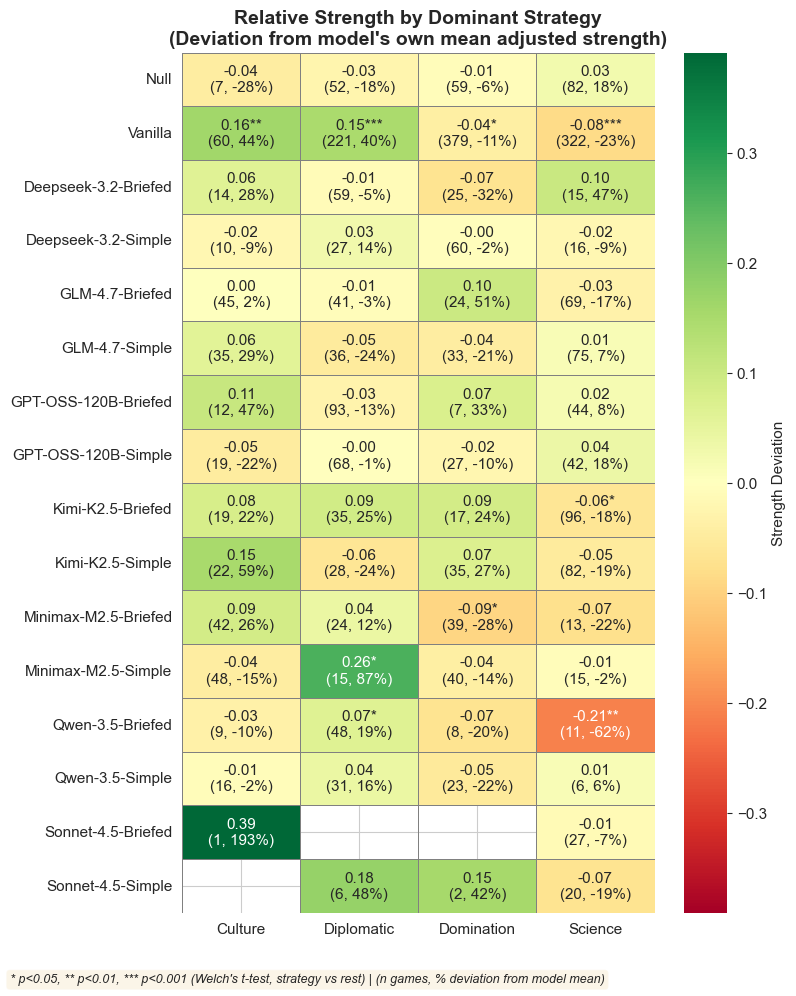

In [39]:
strength_df = df[['player_type', 'dominant_strategy', 'adjusted_strength']].dropna()

# Each model's overall mean strength
pt_means = strength_df.groupby('player_type')['adjusted_strength'].mean()

dev_data, pval_data, count_data, pct_data = [], [], [], []
for pt in player_types:
    pt_df = strength_df[strength_df['player_type'] == pt]
    pt_mean = pt_means[pt]
    dev_row, pval_row, count_row, pct_row = {}, {}, {}, {}

    for s in strategies:
        in_s = pt_df[pt_df['dominant_strategy'] == s]['adjusted_strength']
        not_s = pt_df[pt_df['dominant_strategy'] != s]['adjusted_strength']

        raw_mean = in_s.mean() if len(in_s) > 0 else np.nan
        dev_row[s] = (raw_mean - pt_mean) if not np.isnan(raw_mean) else np.nan

        if len(in_s) >= 2 and len(not_s) >= 2:
            _, p = scipy_stats.ttest_ind(in_s, not_s, equal_var=False)
            pval_row[s] = p
        else:
            pval_row[s] = np.nan

        count_row[s] = len(in_s)
        pct_dev = ((raw_mean - pt_mean) / pt_mean * 100) if (not np.isnan(raw_mean) and pt_mean != 0) else np.nan
        pct_row[s] = pct_dev

    dev_data.append(dev_row)
    pval_data.append(pval_row)
    count_data.append(count_row)
    pct_data.append(pct_row)

dev_df = pd.DataFrame(dev_data, index=player_types)
pval_df = pd.DataFrame(pval_data, index=player_types)
count_df = pd.DataFrame(count_data, index=player_types)
pct_df = pd.DataFrame(pct_data, index=player_types)

max_abs = max(abs(dev_df.min().min()), abs(dev_df.max().max()), 0.01)

fig, ax = plot_coefficient_heatmap(
    dev_df, pval_df, count_df, pct_df,
    title='Relative Strength by Dominant Strategy\n(Deviation from model\'s own mean adjusted strength)',
    cbar_label='Strength Deviation',
    vmin=-max_abs, vmax=max_abs, center=0, cmap='RdYlGn',
    footnote='* p<0.05, ** p<0.01, *** p<0.001 (Welch\'s t-test, strategy vs rest) | (n games, % deviation from model mean)'
)
plt.show()

## Relative Strength vs Vanilla by Dominant Strategy

When pursuing a given dominant strategy, how does each model's adjusted strength compare to Vanilla's mean adjusted strength for that same strategy? Positive = stronger than Vanilla at this strategy.

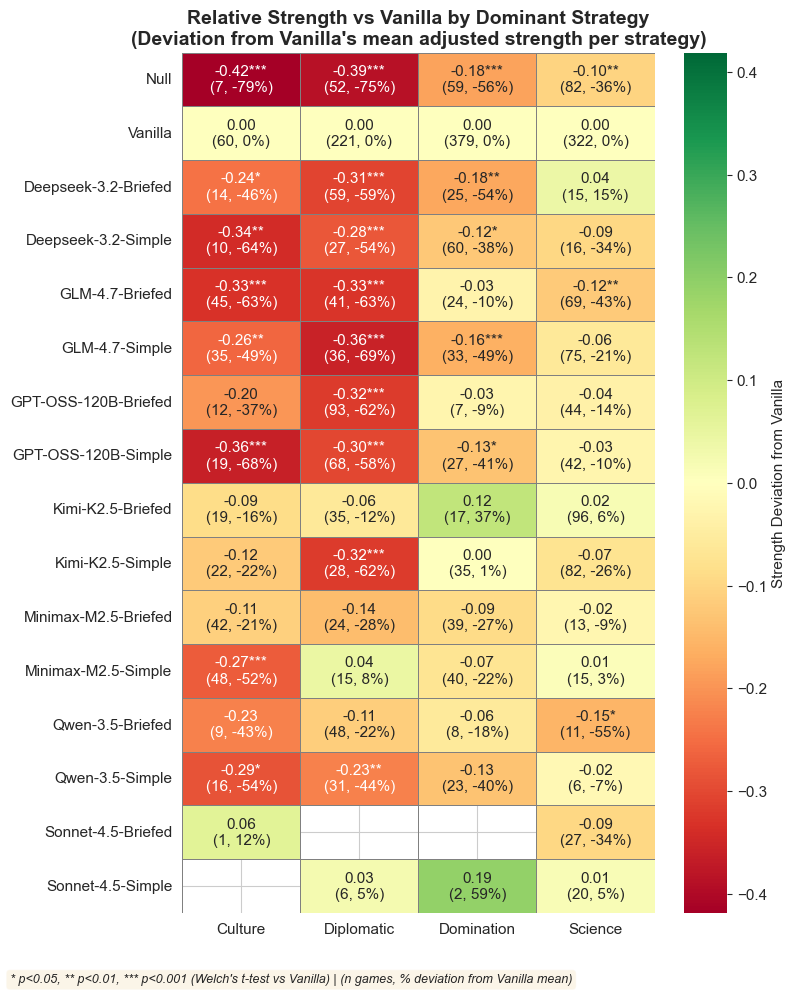

In [40]:
strength_df = df[['player_type', 'dominant_strategy', 'adjusted_strength']].dropna()

# Vanilla's mean adjusted strength per dominant strategy (the baseline)
vanilla_df = strength_df[strength_df['player_type'] == 'Vanilla']
vanilla_means = vanilla_df.groupby('dominant_strategy')['adjusted_strength'].mean()

dev_data, pval_data, count_data, pct_data = [], [], [], []
for pt in player_types:
    pt_df = strength_df[strength_df['player_type'] == pt]
    dev_row, pval_row, count_row, pct_row = {}, {}, {}, {}

    for s in strategies:
        in_s = pt_df[pt_df['dominant_strategy'] == s]['adjusted_strength']
        vanilla_s = vanilla_df[vanilla_df['dominant_strategy'] == s]['adjusted_strength']
        vanilla_mean = vanilla_means.get(s, np.nan)

        raw_mean = in_s.mean() if len(in_s) > 0 else np.nan
        dev_row[s] = (raw_mean - vanilla_mean) if not np.isnan(raw_mean) else np.nan

        # Welch's t-test: model's strength (this strategy) vs Vanilla's strength (same strategy)
        if len(in_s) >= 2 and len(vanilla_s) >= 2:
            _, p = scipy_stats.ttest_ind(in_s, vanilla_s, equal_var=False)
            pval_row[s] = p
        else:
            pval_row[s] = np.nan

        count_row[s] = len(in_s)
        pct_dev = ((raw_mean - vanilla_mean) / vanilla_mean * 100) if (not np.isnan(raw_mean) and vanilla_mean != 0) else np.nan
        pct_row[s] = pct_dev

    dev_data.append(dev_row)
    pval_data.append(pval_row)
    count_data.append(count_row)
    pct_data.append(pct_row)

dev_df = pd.DataFrame(dev_data, index=player_types)
pval_df = pd.DataFrame(pval_data, index=player_types)
count_df = pd.DataFrame(count_data, index=player_types)
pct_df = pd.DataFrame(pct_data, index=player_types)

max_abs = max(abs(dev_df.min().min()), abs(dev_df.max().max()), 0.01)

fig, ax = plot_coefficient_heatmap(
    dev_df, pval_df, count_df, pct_df,
    title='Relative Strength vs Vanilla by Dominant Strategy\n(Deviation from Vanilla\'s mean adjusted strength per strategy)',
    cbar_label='Strength Deviation from Vanilla',
    vmin=-max_abs, vmax=max_abs, center=0, cmap='RdYlGn',
    footnote='* p<0.05, ** p<0.01, *** p<0.001 (Welch\'s t-test vs Vanilla) | (n games, % deviation from Vanilla mean)'
)
plt.show()

## Strength Trajectory by Dominant Strategy

Predicted win probability over turn progress, one subplot per player type. Lines colored by dominant strategy (foregrounded); overall average backgrounded in gray.

In [41]:
# Load predictions and join with panel for player_type + dominant_strategy
pred_df = pd.read_csv('../models/output/attention_mlp_predictions.csv')
panel_df = load_panel_data(csv_path='../panel_data.csv', print_metadata=False)

# Get dominant_strategy and player_type from panel
panel_cols = df[['game_id', 'player_id', 'player_type', 'dominant_strategy']].drop_duplicates()
pred_merged = pred_df.merge(panel_cols, on=['game_id', 'player_id'], how='left')
pred_merged = pred_merged.dropna(subset=['dominant_strategy', 'player_type'])

# Bin turn_progress
n_bins = 20
pred_merged['tp_bin'] = pd.cut(pred_merged['turn_progress'], bins=n_bins, labels=False) / n_bins

print(f'Predictions: {len(pred_merged)} rows, {pred_merged["player_type"].nunique()} player types')
print(f'Dominant strategies in predictions: {sorted(pred_merged["dominant_strategy"].unique())}')

Predictions: 1219192 rows, 16 player types
Dominant strategies in predictions: ['Culture', 'Diplomatic', 'Domination', 'Science']


In [42]:
# Consistent strategy colors across all subplots
strat_types = sorted(pred_merged['dominant_strategy'].unique())
STRATEGY_COLORS = {
    'Culture': '#8B5CF6',      # violet
    'Diplomatic': '#F59E0B',   # amber
    'Domination': '#EF4444',   # red
    'Science': '#3B82F6',      # blue
}
strat_color_map = {s: STRATEGY_COLORS.get(s, '#888888') for s in strat_types}

player_types_pred = sort_player_types(pred_merged['player_type'].unique())
n_cols = 3
n_rows = int(np.ceil(len(player_types_pred) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=True, sharey=True)
axes_flat = axes.flatten()

for idx, pt in enumerate(player_types_pred):
    ax = axes_flat[idx]
    pt_data = pred_merged[pred_merged['player_type'] == pt]

    # Average line — backgrounded (gray, thin, behind everything)
    avg = pt_data.groupby('tp_bin')['predicted_win_probability'].agg(['mean', 'sem']).reset_index()
    ax.plot(avg['tp_bin'], avg['mean'], color='#AAAAAA', linewidth=1.5,
            linestyle='--', label='Average', zorder=1)
    ax.fill_between(avg['tp_bin'],
                    avg['mean'] - 1.96 * avg['sem'],
                    avg['mean'] + 1.96 * avg['sem'],
                    color='#AAAAAA', alpha=0.1, zorder=1)

    # Strategy-colored lines — foregrounded
    for s in strat_types:
        s_data = pt_data[pt_data['dominant_strategy'] == s]
        if len(s_data) == 0:
            continue
        grouped = s_data.groupby('tp_bin')['predicted_win_probability'].agg(['mean', 'sem']).reset_index()
        ax.plot(grouped['tp_bin'], grouped['mean'], color=strat_color_map[s],
                linewidth=2, label=s, zorder=3)
        ax.fill_between(grouped['tp_bin'],
                        grouped['mean'] - 1.96 * grouped['sem'],
                        grouped['mean'] + 1.96 * grouped['sem'],
                        color=strat_color_map[s], alpha=0.1, zorder=2)

    ax.set_title(pt, fontsize=10, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.axhline(y=0.25, color='gray', linestyle=':', alpha=0.4, linewidth=0.8)

# Remove empty subplots
for idx in range(len(player_types_pred), len(axes_flat)):
    axes_flat[idx].set_visible(False)

fig.supxlabel('Turn Progress', fontsize=12)
fig.supylabel('Predicted Win Probability', fontsize=12)

# Single legend from the first subplot
handles, labels = axes_flat[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(strat_types) + 1,
           fontsize=9, bbox_to_anchor=(0.5, -0.02))

fig.suptitle('Predicted Strength Trajectory by Dominant Strategy', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

## Save

In [43]:
strategy_elo.to_csv('../ratings/output/strategy_elo_ratings.csv', index=False)
print(f'Saved {len(strategy_elo)} ratings to ratings/output/strategy_elo_ratings.csv')

Saved 60 ratings to ratings/output/strategy_elo_ratings.csv
